In [1]:
import sys
sys.path.insert(0,"../")

In [2]:
import argparse

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger, MLFlowLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os
import torch

import matplotlib.pyplot as plt

import numpy as np

import wandb
api = wandb.Api()

from causalode import models, data_utils, cv_data_utils, covid_data_utils
from azureml.core.run import Run
from causalode.utils import str2bool

import scipy

In [3]:
run_name = "288ywy2d"

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

def update_dict(main_dict, new_dict):
    for key in new_dict.keys():
        main_dict[key].append(new_dict[key])


print(run_name)
PATH = "./wandb/"
paths = [p for p in os.listdir(PATH) if run_name in p]
assert(len(paths)==1)
PATH += paths[0] + "/files/causalode/"+run_name+"/checkpoints/"
PATH+=os.listdir(PATH)[0]
model_cls = models.VariationalSDE
model = model_cls.load_from_checkpoint(PATH)

hparams = dict(model.hparams)

if hparams["dataset_name"]=="cv":
    dataset_cls = cv_data_utils.CVDataModule
else:
    dataset_cls = data_utils.PendulumDataModule
dataset = dataset_cls(**hparams)
dataset.prepare_data()
print(f"Loaded model and data from {PATH}")

288ywy2d
Loaded model and data from ./wandb/run-20210722_122011-288ywy2d/files/causalode/288ywy2d/checkpoints/last.ckpt


In [5]:
repeats = 10
model.eval()

Y_hat_samples_list = []
Y_alea_std_list = []
Y_hat_cf_samples_list = []
Y_alea_std_cf_list = []
Y_list = []
Y_cf_list = []
p_list = []
T_list = []
X_list = []

with torch.no_grad():
    for i,batch in enumerate(dataset.test_dataloader()):
        X,Y, T, Y_cf, p, thetas_0 = batch
        Y_list.append(Y)
        Y_cf_list.append(Y_cf)
        p_list.append(p)
        T_list.append(T)
        X_list.append(X)
        times = torch.arange(11).float()
        times_eval = torch.linspace(0,11).float()
        #times = torch.arange(11).float()
    
        
        Y_hat_list = []
        Y_hat_cf_list = []
        Y_alea_std = []
        Y_alea_cf_std = []
        for _ in range(repeats):
            Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times_eval)
            
            if model.std_dev:
                Y_hat, Y_std = torch.chunk(Y_hat,2,-1)
            else:
                #Y_std = model.output_scale.repeat(Y_hat.shape)
                Y_std = torch.zeros_like(Y_hat)
            
            Y_hat_list.append(Y_hat)
            Y_alea_std.append(torch.sqrt(torch.sigmoid(Y_std)))
            
            T_cf = (~T.bool()).float()
            Y_hat_cf, reg, logqp = model(X,T_cf,return_decoded_u=True, times=times_eval)
            
            if model.std_dev:
                Y_hat_cf, Y_std_cf = torch.chunk(Y_hat_cf,2,-1)
            else:
                #Y_std_cf = model.output_scale.repeat(Y_hat_cf.shape)
                Y_std_cf = torch.zeros_like(Y_hat_cf)
            
            Y_hat_cf_list.append(Y_hat_cf)
            Y_alea_cf_std.append(torch.sqrt(torch.sigmoid(Y_std_cf)))
            
        Y_hat_samples = torch.cat(Y_hat_list,0)
        Y_alea_std = torch.cat(Y_alea_std,0)
        Y_hat_cf_samples = torch.cat(Y_hat_cf_list,0)
        Y_alea_std_cf = torch.cat(Y_alea_cf_std,0)
        
        Y_hat_samples_list.append(Y_hat_samples)
        Y_alea_std_list.append(Y_alea_std)
        Y_hat_cf_samples_list.append(Y_hat_cf_samples)
        Y_alea_std_cf_list.append(Y_alea_std_cf)

Y_hat_samples = torch.cat(Y_hat_samples_list,1)
Y_alea_std = torch.cat(Y_alea_std_list,1)
Y_hat_cf_samples = torch.cat(Y_hat_cf_samples_list,1)
Y_alea_std_cf = torch.cat(Y_alea_std_cf_list,1)

Y = torch.cat(Y_list,0)
Y_cf = torch.cat(Y_cf_list,0)
p = torch.cat(p_list,0)
T = torch.cat(T_list,0)
X = torch.cat(X_list,0)

Treatment : 0.0
Probability of Treatment = 1 : 0.9022297430422203
Propensity Score: 10.228059443802334


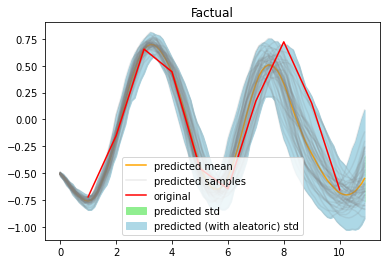

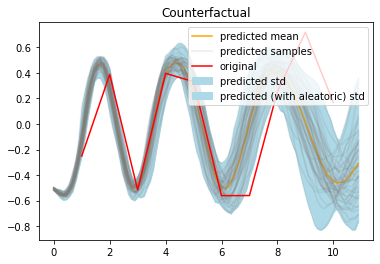

In [6]:
series_idx = 14

print(f"Treatment : {T[series_idx]}")
print(f"Probability of Treatment = 1 : {p[series_idx]}")
propensity_score = 1/((1-T[series_idx])*(1-p[series_idx])+T[series_idx]*p[series_idx])
print(f"Propensity Score: {propensity_score}")

plt.figure()
Y_hat_mean = Y_hat_samples.mean(0)
Y_hat_std  = Y_hat_samples.std(0)

Y_hat_up = (Y_hat_samples+0*1.96*Y_alea_std).max(0)[0]
Y_hat_down = (Y_hat_samples-0*1.96*Y_alea_std).min(0)[0]
Y_hat_diff = Y_hat_up - Y_hat_down

plt.plot(times_eval[:-1],Y_hat_mean[series_idx], label = "predicted mean", color = "orange")
plt.fill_between(times_eval[:-1],(Y_hat_mean[series_idx]-Y_hat_std[series_idx]).reshape(-1),(Y_hat_mean[series_idx]+Y_hat_std[series_idx]).reshape(-1), color = "lightgreen", label = "predicted std")
plt.fill_between(times_eval[:-1],Y_hat_down[series_idx].reshape(-1),Y_hat_up[series_idx].reshape(-1), color = "lightblue", label = "predicted (with aleatoric) std")

for r in range(Y_hat_samples.shape[0]):
    if r == 0:
        plt.plot(times_eval[:-1],Y_hat_samples[r,series_idx,...],label = "predicted samples",color = "grey", alpha = 0.15)
    else:
        plt.plot(times_eval[:-1],Y_hat_samples[r,series_idx,...],color = "grey", alpha = 0.15)
        
plt.plot(times[:-1]+1,Y[series_idx], label = "original", color = "red")
plt.title("Factual")
plt.legend()


plt.figure()
Y_hat_cf_mean = Y_hat_cf_samples.mean(0)
Y_hat_cf_std  = Y_hat_cf_samples.std(0)

Y_hat_cf_up = (Y_hat_cf_samples+0*1.96*Y_alea_std_cf).max(0)[0]
Y_hat_cf_down = (Y_hat_cf_samples-0*1.96*Y_alea_std_cf).min(0)[0]
Y_hat_cf_diff = Y_hat_cf_up - Y_hat_cf_down

plt.plot(times_eval[:-1],Y_hat_cf_mean[series_idx], label = "predicted mean", color = "orange")
plt.fill_between(times_eval[:-1],(Y_hat_cf_mean[series_idx]-Y_hat_cf_std[series_idx]).reshape(-1),(Y_hat_cf_mean[series_idx]+Y_hat_cf_std[series_idx]).reshape(-1), color = "lightblue", label = "predicted std")
plt.fill_between(times_eval[:-1],Y_hat_cf_down[series_idx].reshape(-1),Y_hat_cf_up[series_idx].reshape(-1), color = "lightblue", label = "predicted (with aleatoric) std")

for r in range(Y_hat_cf_samples.shape[0]):
    if r == 0:
        plt.plot(times_eval[:-1],Y_hat_cf_samples[r,series_idx,...],label = "predicted samples",color = "grey", alpha = 0.15)
    else:
        plt.plot(times_eval[:-1],Y_hat_cf_samples[r,series_idx,...],color = "grey", alpha = 0.15)
        
plt.plot(times[:-1]+1,Y_cf[series_idx], label = "original", color = "red")
plt.title("Counterfactual")
plt.legend()

In [57]:
blue_color = "#2E3192"
blue_fill = "#5590CC"
green_color = "#006838"
green_fill = "#99CC99"

num_trajectories = 10

Treatment : 1.0
Probability of Treatment = 1 : 0.9650627314849773
Propensity Score: 1.0362020699537982


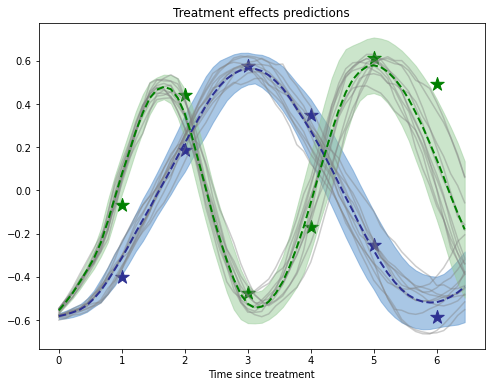

In [62]:
series_idx = 18
lim_left = 6
lim_left_continuous = 6.5
#times_eval = times_eval[times_eval<=lim_left]
left_mask = times_eval[:-1]<=lim_left_continuous

print(f"Treatment : {T[series_idx]}")
print(f"Probability of Treatment = 1 : {p[series_idx]}")
propensity_score = 1/((1-T[series_idx])*(1-p[series_idx])+T[series_idx]*p[series_idx])
print(f"Propensity Score: {propensity_score}")

plt.figure(figsize=(8,6))
Y_hat_mean = Y_hat_samples.mean(0)
Y_hat_std  = Y_hat_samples.std(0)

Y_hat_up = (Y_hat_samples+0*1.96*Y_alea_std).max(0)[0]
Y_hat_down = (Y_hat_samples-0*1.96*Y_alea_std).min(0)[0]
Y_hat_diff = (Y_hat_up - Y_hat_down)

Y_hat_diff = 1.96*Y_hat_samples.std(0)
Y_hat_up = Y_hat_samples.mean(0) - Y_hat_diff
Y_hat_down = Y_hat_samples.mean(0) + Y_hat_diff

Y_hat_cf_mean = Y_hat_cf_samples.mean(0)
Y_hat_cf_std  = Y_hat_cf_samples.std(0)

Y_hat_cf_up = (Y_hat_cf_samples+0*1.96*Y_alea_std_cf).max(0)[0]
Y_hat_cf_down = (Y_hat_cf_samples-0*1.96*Y_alea_std_cf).min(0)[0]
Y_hat_cf_diff = Y_hat_cf_up - Y_hat_cf_down

Y_hat_cf_diff = 1.96*Y_hat_cf_samples.std(0)
Y_hat_cf_up = Y_hat_cf_samples.mean(0) - Y_hat_cf_diff
Y_hat_cf_down = Y_hat_cf_samples.mean(0) + Y_hat_cf_diff

#plt.plot(times_eval[:-1][left_mask],Y_hat_cf_mean[series_idx][left_mask], color = "blue", linestyle = "--")
#plt.fill_between(times[:-1],(Y_hat_cf_mean[series_idx]-Y_hat_cf_std[series_idx]).reshape(-1),(Y_hat_cf_mean[series_idx]+Y_hat_cf_std[series_idx]).reshape(-1), color = "lightblue", label = "predicted std")
plt.fill_between(times_eval[:-1][left_mask],Y_hat_cf_down[series_idx][left_mask].reshape(-1),Y_hat_cf_up[series_idx][left_mask].reshape(-1), color = blue_fill, label = "predicted std",alpha=0.5)
plt.fill_between(times_eval[:-1][left_mask],Y_hat_down[series_idx][left_mask].reshape(-1),Y_hat_up[series_idx][left_mask].reshape(-1), color = green_fill,alpha=0.5)

for r in range(Y_hat_cf_samples.shape[0]):
    if r > num_trajectories:
        break
    if r == 0:
        plt.plot(times_eval[:-1][left_mask],Y_hat_cf_samples[r,series_idx,...][left_mask],label = "predicted samples",color = "grey", alpha = 0.4)
    else:
        plt.plot(times_eval[:-1][left_mask],Y_hat_cf_samples[r,series_idx,...][left_mask],color = "grey", alpha = 0.4)
        
for r in range(Y_hat_samples.shape[0]):
    if r > num_trajectories:
        break
    if r == 0:
        plt.plot(times_eval[:-1][left_mask],Y_hat_samples[r,series_idx,...][left_mask],color = "grey", alpha = 0.4)
    else:
        plt.plot(times_eval[:-1][left_mask],Y_hat_samples[r,series_idx,...][left_mask],color = "grey", alpha = 0.4)

plt.plot(times_eval[:-1][left_mask],Y_hat_cf_mean[series_idx][left_mask], color = blue_color, linestyle = "--",linewidth = 2)
plt.plot(times_eval[:-1][left_mask],Y_hat_mean[series_idx][left_mask], label = "predicted mean", color = "green", linestyle = "--",linewidth = 2)


plt.scatter(times[:-1][:lim_left]+1,Y_cf[series_idx][:lim_left], label = "truth", color = blue_color,marker="*", s=200)
plt.scatter(times[:-1][:lim_left]+1,Y[series_idx][:lim_left], color = "green",marker="*", s=200)


plt.title("Treatment effects predictions")
plt.xlabel("Time since treatment")
#plt.legend()
plt.savefig("./plots/clean_example_cv.pdf")
plt.show()